This notebook will try and predict one NM from another one using the low dimensional embeddings from CEBRA.

In [1]:
import sys
import os # my addtion

import numpy as np
import itertools
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.mplot3d import Axes3D
from scipy.integrate import solve_ivp
import cebra.data
import torch
import cebra.integrations
#import cebra.datasets
from cebra import CEBRA
import torch
import pickle
import cebra_pack.utils as cp
import sklearn.linear_model
import logging
import glob


from matplotlib.collections import LineCollection
import pandas as pd

/Users/brian.gitahi/anaconda3/envs/CEBRA_Pack/lib/python3.9/site-packages/cebra/datasets/__init__.py:103: UserWarning: Could not initialize one or more datasets: No module named 'h5py'. For using the datasets, consider installing the [datasets] extension via pip.
  warnings.warn(f"Could not initialize one or more datasets: {e}. "


## A. Load the Data

Here we load data from the Fibre Photometry pipeline of 4 Neuromodulators (DA, 5HT, ACh, NE) recorded in the Nucleus Acumbens region. The main neural data will be in the form of dF_F traces of these 4 Neuromodulators (NMs). These will be stored in a 2D array, 'all_nms'.

In [2]:
# load the dataframe that contains data from 1 session
try:
    df_trials_ses = pickle.load(open('/Users/brian.gitahi/Desktop/AIND/CEBRA/Git/CEBRA-Demo/data/CO data/df.pkl', "rb"))
    print("Loaded df.pkl from the local path.")
except FileNotFoundError:
    df_trials_ses = pickle.load(open('/data/df.pkl', "rb"))
    print("Loaded df.pkl from the CO path.")


Loaded df.pkl from the local path.


In [3]:
n_trials = 1765

In [4]:
# download the dictionary containing the traces (you can download this locally and replcace the path)
try:
    traces = pickle.load(open('/Users/brian.gitahi/Desktop/AIND/CEBRA/Git/CEBRA-Demo/data/CO data/traces.pkl', "rb"))
    print("Loaded traces.pkl from the local path.")
except FileNotFoundError:
    traces = pickle.load(open('/data/traces.pkl', "rb"))
    print("Loaded traces.pkl from the alternate path.")


Loaded traces.pkl from the local path.


In [5]:
# load the trace times (you can download this locally and replcace the path)
try:
    trace_times = np.load('/Users/brian.gitahi/Desktop/AIND/CEBRA/Git/CEBRA-Demo/data/CO data/Trace times.npy', allow_pickle=True)
    print("Loaded Trace times.npy from the local path.")
except FileNotFoundError:
    trace_times = np.load('/data/Trace times.npy', allow_pickle=True)
    print("Loaded Trace times.npy from the alternate path.")

Loaded Trace times.npy from the local path.


In [6]:
# get the choice time 
choice_times = df_trials_ses['choice_time'][0:n_trials].to_numpy()

In [7]:
# Combine the traces into one 2D array
all_nms = np.array([traces[trace] for trace in traces.keys()])
all_nms = np.transpose(all_nms)
all_nms.shape

(218572, 4)

## B. Format the Data

In [8]:
# get all NMs
formatted_nms, reward_labels, choice_labels, rpe_labels_ = cp.format_data(all_nms,df=df_trials_ses,trace_times_=trace_times, choice_times_=choice_times)

neural tensor shape:  torch.Size([1717, 80])
reward labels shape:  (1717,)
choice labels shape:  (1717,)
rpe labels shape: (1717,)


In [9]:
# get individual NMs
ind_nms = cp.individual_datasets(traces_=traces)

shape of formatted array: (218572, 1)
shape of formatted array: (218572, 1)
shape of formatted array: (218572, 1)
shape of formatted array: (218572, 1)


In [10]:
torch.cuda.is_available()

False

In [11]:
formatted_ind_nms = [cp.format_data(ind_nm, df_trials_ses, trace_times, choice_times)[0] for ind_nm in ind_nms]

neural tensor shape:  torch.Size([1717, 20])
reward labels shape:  (1717,)
choice labels shape:  (1717,)
rpe labels shape: (1717,)
neural tensor shape:  torch.Size([1717, 20])
reward labels shape:  (1717,)
choice labels shape:  (1717,)
rpe labels shape: (1717,)
neural tensor shape:  torch.Size([1717, 20])
reward labels shape:  (1717,)
choice labels shape:  (1717,)
rpe labels shape: (1717,)
neural tensor shape:  torch.Size([1717, 20])
reward labels shape:  (1717,)
choice labels shape:  (1717,)
rpe labels shape: (1717,)


In [12]:
rewarded, unrewarded = cp.define_label_classes(reward_labels)

In [13]:
formatted_nms.shape[0]

1717

In [14]:
# add zeros to the individual nms data so the input dimensionality is the same as all_nms
zeros = np.zeros((formatted_nms.shape[0],60))

In [15]:
# instead of zeros, add nans and compare with what we get
nans = np.full([formatted_nms.shape[0],60], np.nan)

In [16]:
# select zeros or nans
filler = zeros

In [17]:
expanded_ind_nms = [torch.from_numpy(np.hstack((ind_nm, filler))) for ind_nm in formatted_ind_nms]

In [18]:
expanded_ind_nms[3][:,18]

tensor([-0.0080,  0.0014, -0.0008,  ...,  0.0019,  0.0020,  0.0025],
       dtype=torch.float64)

In [19]:
formatted_ind_nms[0].shape

torch.Size([1717, 20])

## C. Build and train the CEBRA model then compute embeddings

In [20]:
# train CEBRA on all nms then produce embeddings for individual nms
def multi_embed_NMs(all_nms, ind_nms, b_label, max_iterations=2000, d=3, metric='euclidean', arch = 'offset10-model-mse'):


    # build time and behaviour models
    cebra_time_model = CEBRA(model_architecture=arch,
                        batch_size=512,
                        learning_rate=3e-4,
                        temperature=1,
                        output_dimension=d,
                        max_iterations=max_iterations,
                        distance=metric,
                        conditional='time',
                        device='cuda_if_available',
                        verbose=True,
                        time_offsets=10) 

    cebra_behaviour_model = CEBRA(model_architecture=arch,
                        batch_size=512,
                        learning_rate=3e-4,
                        temperature=1,
                        output_dimension=d,
                        max_iterations=max_iterations,
                        distance=metric,
                        conditional='time_delta',
                        device='cuda_if_available',
                        verbose=True,
                        time_offsets=10)

    # train them both
    cebra_time_model.fit(all_nms)
    cebra_behaviour_model.fit(all_nms, b_label)

    # compute the embeddings for the individual nms
    time_embeddings = [cebra_time_model.transform(ind_nm) for ind_nm in ind_nms]
    behaviour_embeddings = [cebra_behaviour_model.transform(ind_nm) for ind_nm in ind_nms]

    # comput embeddings for all nms
    time_embeddings.append(cebra_time_model.transform(all_nms))
    behaviour_embeddings.append(cebra_behaviour_model.transform(all_nms))


    return time_embeddings, behaviour_embeddings

In [21]:
time_embeddings, behaviour_embeddings = multi_embed_NMs(all_nms=formatted_nms, ind_nms=expanded_ind_nms,b_label=reward_labels)

pos:  0.8682 neg:  3.1093 total:  3.9775 temperature:  1.0000: 100%|██████████| 2000/2000 [01:09<00:00, 28.65it/s]
pos:  0.3008 neg:  5.4568 total:  5.7576 temperature:  1.0000: 100%|██████████| 2000/2000 [00:51<00:00, 39.14it/s]


# D. View Embeddings

Now let's view the embeddings and compare them with those generated from independent CEBRA models.

In [22]:
# define a function to view the embeddings
def view(time_embedding, behaviour_embedding, labels, label_classes, scores=None, titles=["Time embedding", "Behaviour embedding"], size=5):
 
    # create a figure and make the plots
    fig = plt.figure(figsize=(17,8))
    gs = gridspec.GridSpec(1, 2, figure=fig)


    ax81 = fig.add_subplot(gs[0,0], projection='3d')
    ax82 = fig.add_subplot(gs[0,1], projection='3d')
    
    for ax in [ax81,ax82]:
        ax.set_xlabel("latent 1", labelpad=0.001, fontsize=13)
        ax.set_ylabel("latent 2", labelpad=0.001, fontsize=13)
        ax.set_zlabel("latent 3", labelpad=0.001, fontsize=13)

        # Hide X and Y axes label marks
        ax.xaxis.set_tick_params(labelbottom=False)
        ax.yaxis.set_tick_params(labelleft=False)
        ax.zaxis.set_tick_params(labelright=False)

        # Hide X and Y axes tick marks
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_zticks([])


    # colour maps
    colours = ['cool', 'plasma', 'spring']

    embeddings = [time_embedding, behaviour_embedding]

    if scores == None:
        scores, errors = np.round(cp.get_auc(embeddings, labels),3)

    # plot the time embedding 
    cebra.plot_embedding(embedding=time_embedding[label_classes[0],:], embedding_labels=labels[label_classes[0]],ax=ax81, markersize=size, title=titles[0], cmap=colours[0])
    cebra.plot_embedding(embedding=time_embedding[label_classes[1],:], embedding_labels=labels[label_classes[1]],ax=ax81, markersize=size, title= f'{titles[0]}, Score:{scores[0]}', cmap=colours[1])


    # plot the behaviour embedding 
    cebra.plot_embedding(embedding=behaviour_embedding[label_classes[0],:], embedding_labels=labels[label_classes[0]],ax=ax82, markersize=size, title=titles[1], cmap=colours[0],)
    cebra.plot_embedding(embedding=behaviour_embedding[label_classes[1],:], embedding_labels=labels[label_classes[1]],ax=ax82,markersize=size, title= f'{titles[1]}, Score: {scores[1]}',  cmap=colours[1])

    gs.tight_layout(figure=fig)

In [23]:
# first make function to make the plots given a list of embeddings
def plot4_embeddings(embeddings, labels , l_class, t=""):

    # number of plots
    n_plots = len(embeddings)

    n_columns = 2
    n_rows = (n_plots + 1) // n_columns

    # create axis
    fig = plt.figure(figsize=(16, 4*n_rows))
    gs = gridspec.GridSpec(n_rows, n_columns, figure=fig)

    # colour 
    c = ['cool','plasma','pink','winter']

    for i, embed in enumerate(embeddings):

        # create the axes
        ax = fig.add_subplot(gs[i // n_columns, i%n_columns], projection='3d')

        ax.set_xlabel("latent 1", labelpad=0.001, fontsize=13)
        ax.set_ylabel("latent 2", labelpad=0.001, fontsize=13)
        ax.set_zlabel("latent 3", labelpad=0.001, fontsize=13)

        # Hide X and Y axes label marks
        ax.xaxis.set_tick_params(labelbottom=False)
        ax.yaxis.set_tick_params(labelleft=False)
        ax.zaxis.set_tick_params(labelright=False)

        # Hide X and Y axes tick marks
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_zticks([])


        aucs, errors = np.round(cp.get_auc(embeddings, labels),3)
        titles=['DA only, AUC:{}'.format(aucs[0]),'NE only, AUC:{}'.format(aucs[1]), '5HT only, AUC:{}'.format(aucs[2]), 'ACh only, AUC:{}'.format(aucs[3]), f'All nms, AUC:{aucs[4]}']


        # plot the embedding
        cebra.plot_embedding(embedding=embed[l_class[0],:], embedding_labels=labels[l_class[0]], ax=ax, markersize=2,title=titles[i], cmap=c[0])
        cebra.plot_embedding(embedding=embed[l_class[1],:], embedding_labels=labels[l_class[1]], ax=ax, markersize=2,title=titles[i], cmap=c[1])

    plt.suptitle(t, fontsize=15)
    plt.tight_layout()
    plt.show()

In [24]:
len(behaviour_embeddings)

5

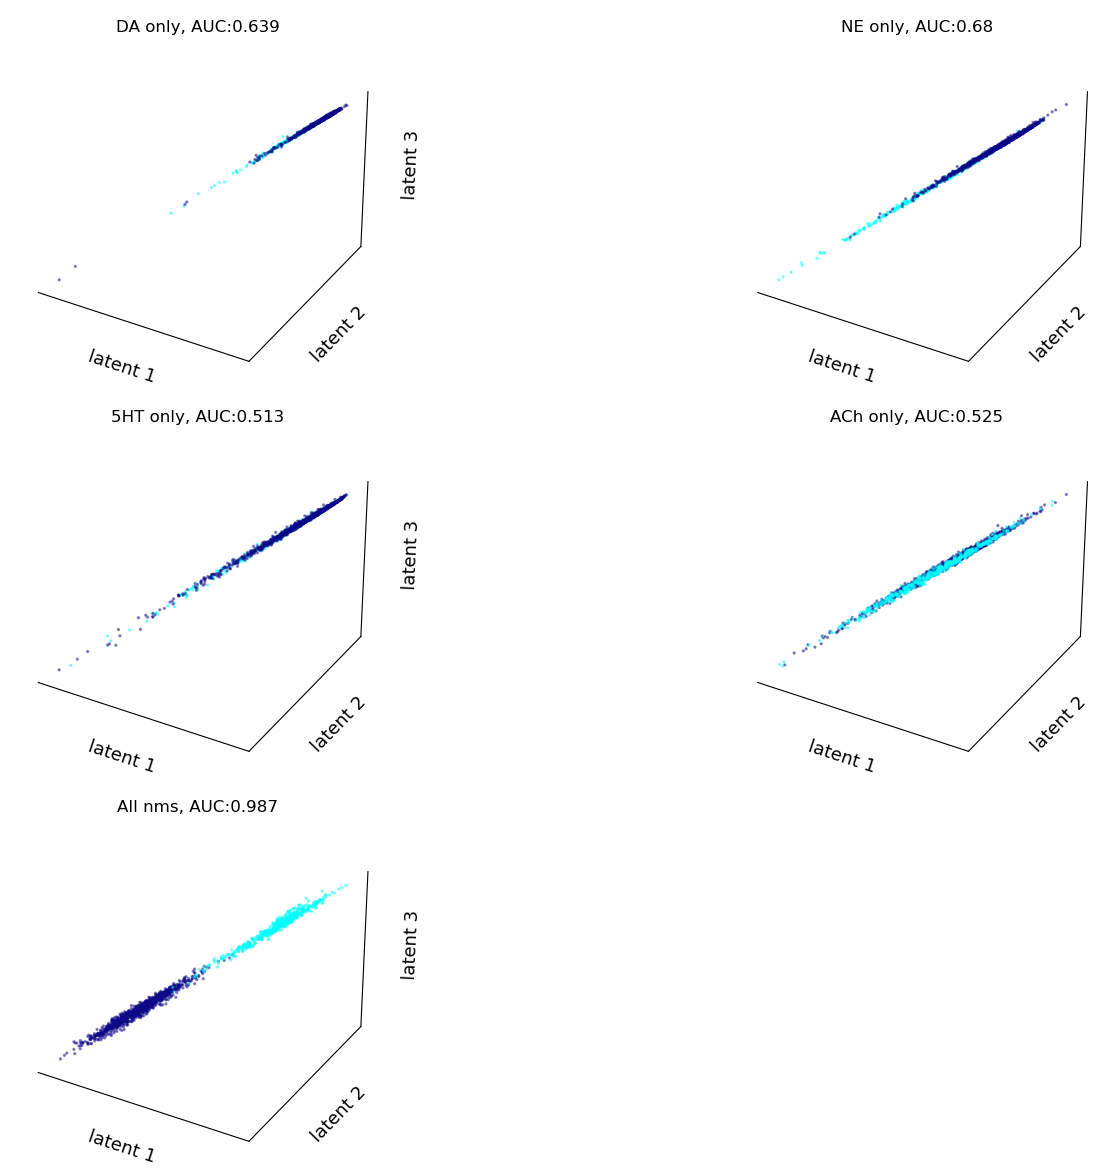

In [25]:
# %matplotlib inline
plot4_embeddings(behaviour_embeddings,reward_labels, [rewarded, unrewarded])

## E. Predict one NM from an embedding of another NM

In [26]:
target_nm = behaviour_embeddings[0]
input_nm = behaviour_embeddings[1]

In [27]:
score, prediction = cp.reconstruction_score(input_nm, target_nm)

In [28]:
score = np.round(score,3)
score

0.493

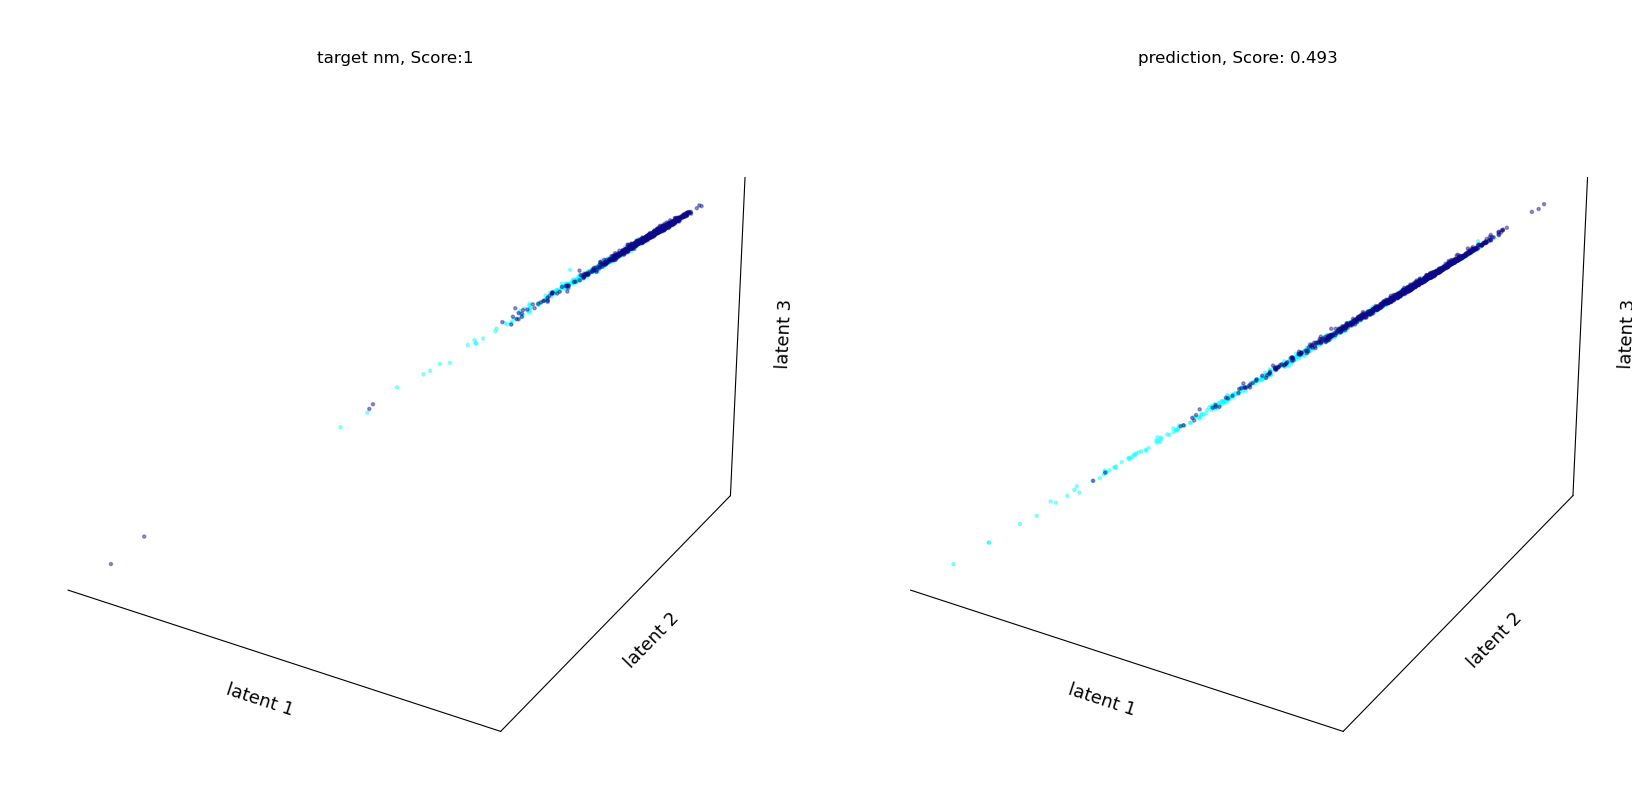

In [29]:
view(target_nm, prediction, labels=reward_labels, label_classes=[rewarded, unrewarded], scores=[1,score], titles=['target nm', 'prediction'])

If you play around with the input and target nms, (the order is: DA, NE, 5HT, ACh), it seems that it is not easy to predict the activity of one NM from another one (all reconstruction scores are below 0.5). However, it is much easier to reconstruct DA and NE from each other.

In [30]:
behaviour_embeddings[0][:,2]

array([-1.6494483 , -8.605659  , -9.011679  , ..., -0.89641184,
       -0.46938214, -0.52138954], dtype=float32)